In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import RandomSampler, Dataset, DataLoader

In [3]:
#demo using CIFAR10
#create dataset with pytorch datset and dataloaders
tf = transforms.Compose([
  torchvision.transforms.ToTensor(),
  transforms.Normalize([0.5]*3, [0.25]*3)
])
TRAIN_BATCH_SIZE = 128

trainset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=tf,
)
trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True, 
    num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=tf,
)
testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=200,
    shuffle=False, 
    num_workers=2
)

In [4]:
trainset.__len__()

50000

In [5]:
img, label = trainset.__getitem__(0)

### Setting up autoencoder

In [4]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, downsample=False, stride=1):
    super(ResidualBlock, self).__init__()
    self.downsample = downsample
    if self.downsample:
      padding = 0
      self.ds_pool = nn.AvgPool2d(kernel_size=kernel_size, stride=stride, padding=padding)
    else:
      padding = 1
    self.conv = nn.Sequential(
      nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
      nn.BatchNorm2d(num_features=out_channels),
      nn.ReLU(),
      nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
      nn.BatchNorm2d(num_features=out_channels)
    )
    self.relu = nn.ReLU()
    self.conv1x1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)

  def forward(self, X):
    X_conv = self.conv(X)
    X = self.conv1x1(X)
    if self.downsample:
      X = self.ds_pool(X)
      X = self.ds_pool(X)
    X = X + X_conv
    X = self.relu(X)
    return X

In [5]:
class UnResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, in_shape, upsample=False, stride=1):
    super(UnResidualBlock, self).__init__()
    self.upsample = upsample
    if self.upsample:
      padding = 0
      size_increase1 = (in_shape - 1) * stride + kernel_size
      size_increase2 = (size_increase1 - 1) * stride + kernel_size
      self.up1 = nn.Upsample(size=size_increase1)
      self.up2 = nn.Upsample(size=size_increase2)
    else:
      padding = 1
    self.conv = nn.Sequential(
      nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
      nn.BatchNorm2d(num_features=out_channels),
      nn.ReLU(),
      nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
      nn.BatchNorm2d(num_features=out_channels)
    )
    self.relu = nn.ReLU()
    self.conv1x1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)

  def forward(self, X):
    X_conv = self.conv(X)
    X = self.conv1x1(X)
    if self.upsample:
      X = self.up1(X)
      X = self.up2(X)
    X = X + X_conv
    X = self.relu(X)
    return X

In [6]:
class ResNet(nn.Module):
  def __init__(self, dropout):
    super(ResNet, self).__init__()
    self.conv_init = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=0),
      nn.BatchNorm2d(num_features=4),
      nn.ReLU()
    )
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)
    self.resblocks = nn.Sequential(
      ResidualBlock(in_channels=4, out_channels=8, kernel_size=4, downsample=True),
      ResidualBlock(in_channels=8, out_channels=16, kernel_size=4, downsample=True),
      ResidualBlock(in_channels=16, out_channels=32, kernel_size=4, downsample=True),
      ResidualBlock(in_channels=32, out_channels=64, kernel_size=4, downsample=True),
      ResidualBlock(in_channels=64, out_channels=128, kernel_size=2, downsample=True),
      nn.Dropout(dropout),
    )
    self.final_layer = nn.Sequential(
      nn.AvgPool2d(kernel_size=3, padding=0, stride=1),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(in_features=128, out_features=64, bias=False),
    )
  
  def forward(self, X):
    X = self.conv_init(X)
    X = self.maxpool(X)
    X = self.resblocks(X)
    X = self.final_layer(X)
    return X

In [7]:
class UnResNet(nn.Module):
  def __init__(self, dropout):
    super(UnResNet, self).__init__()
    self.unproject = nn.Sequential(
      nn.Linear(in_features=64, out_features=128),
      nn.Unflatten(dim=-1, unflattened_size=[128, 1, 1]),
      nn.ReLU(),
      nn.Upsample(size=3),
    )
    self.unresblocks = nn.Sequential(
      nn.Dropout(dropout),
      UnResidualBlock(in_channels=128, out_channels=64, kernel_size=2, in_shape=3, upsample=True),
      UnResidualBlock(in_channels=64, out_channels=32, kernel_size=4, in_shape=5, upsample=True),
      UnResidualBlock(in_channels=32, out_channels=16, kernel_size=4, in_shape=11, upsample=True),
      UnResidualBlock(in_channels=16, out_channels=8, kernel_size=4, in_shape=17, upsample=True),
      UnResidualBlock(in_channels=8, out_channels=4, kernel_size=4, in_shape=23, upsample=True), 
    )
    self.rev_maxpool = nn.Upsample(size=30)
    self.rev_conv_init = nn.Sequential(
      nn.ReLU(),
      nn.BatchNorm2d(num_features=4),
      nn.ConvTranspose2d(in_channels=4, out_channels=3, kernel_size=3, stride=1, padding=0),       
    )

  def forward(self, X):
    X = self.unproject(X)
    X = self.unresblocks(X)
    X = self.rev_maxpool(X)
    X = self.rev_conv_init(X)
    return X

In [8]:
class ResNetAutoEncoder(nn.Module):
  def __init__(self, dropout=0.2):
    super(ResNetAutoEncoder, self).__init__()
    self.resnet = ResNet(dropout)
    self.unresnet = UnResNet(dropout)
  
  def forward(self, X):
    X_emb = self.resnet(X) #embed X
    X_repr = self.unresnet(X_emb) #reproduce X
    return X_emb, X_repr

### Train 

In [9]:
device = torch.device('xpu')
rnae = ResNetAutoEncoder()
rnae.to(device)
sum([p.numel() for p in rnae.parameters()])

384475

In [12]:
batch, _ = next(iter(trainloader))
batch = batch.to(device)
batch_emb, batch_repr = rnae(batch)
batch.shape, batch_emb.shape, batch_repr.shape

(torch.Size([128, 3, 32, 32]),
 torch.Size([128, 64]),
 torch.Size([128, 3, 32, 32]))

In [13]:
criterion = nn.MSELoss()
lr = 1e-3
weight_decay = 1e-3
optimizer = optim.Adam(params=rnae.parameters(), lr=lr, weight_decay=1e-3)

In [14]:
for epoch in range(10):
  for idx, (inputs, _) in enumerate(testloader, 0):
    inputs = inputs.to(device)
    emb, repr = rnae(inputs)
    optimizer.zero_grad()
    loss = criterion(repr, inputs)
    loss.backward()
    optimizer.step()

    if idx % 40 == 0:
      print(f'epoch {epoch}, batch {idx}: loss = {loss.item()}')

import datetime
ts = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
torch.save(rnae, f'rnae_{ts}.pt')


epoch 0, batch 0: loss = 1.4745200872421265
epoch 0, batch 40: loss = 0.8160939812660217
epoch 1, batch 0: loss = 0.7357564568519592
epoch 1, batch 40: loss = 0.6051818132400513
epoch 2, batch 0: loss = 0.5927568674087524
epoch 2, batch 40: loss = 0.5631039142608643
epoch 3, batch 0: loss = 0.5576099753379822
epoch 3, batch 40: loss = 0.5192616581916809
epoch 4, batch 0: loss = 0.5217704772949219
epoch 4, batch 40: loss = 0.4928357005119324
epoch 5, batch 0: loss = 0.49778005480766296
epoch 5, batch 40: loss = 0.4751507639884949
epoch 6, batch 0: loss = 0.4847204089164734
epoch 6, batch 40: loss = 0.4664023518562317
epoch 7, batch 0: loss = 0.46835973858833313
epoch 7, batch 40: loss = 0.44965440034866333
epoch 8, batch 0: loss = 0.45284759998321533
epoch 8, batch 40: loss = 0.4340299665927887
epoch 9, batch 0: loss = 0.43920350074768066
epoch 9, batch 40: loss = 0.43229803442955017


### Demonstrate embeddings with clustering

In [15]:
sampler = RandomSampler(trainset)
sampling_dataloader = DataLoader(trainset, batch_size=100, sampler=sampler)

In [16]:
def compare_cos_similarity(model, sampling_dataloader, device):
  x, y = next(iter(sampling_dataloader))
  x, y = x.to(device), y.to(device)
  x_emb, _ = model(x)

  x_emb_norm = F.normalize(x_emb.squeeze(1), p=2.0, dim=1)
  cos_sim = x_emb_norm @ x_emb_norm.T
  cos_sim = (cos_sim.cpu() + 1) / 2 #add one and divide by 2 so that values range from 0 to 1, not -1 to 1 

  y_cpu = y.cpu()
  print('class    |  same class  |  diff class  |  ratio (same / diff)')
  print('-------------------------------------------------------------')
  for label in set(y_cpu.numpy()):
    idxs = (y_cpu == label).nonzero().squeeze(1)
    not_idxs = (y_cpu != label).nonzero().squeeze(1)
    mean_dot_prod_sharedclass = cos_sim[idxs][:, idxs].mean()
    mean_dot_prod_diffclass = cos_sim[idxs][:, not_idxs].mean()
    ratio = mean_dot_prod_sharedclass / mean_dot_prod_diffclass
    print(f'class {label}        {mean_dot_prod_sharedclass:.2f}           {mean_dot_prod_diffclass:.2f}          {ratio:.2f}')

In [17]:
compare_cos_similarity(rnae, testloader, device)

class    |  same class  |  diff class  |  ratio (same / diff)
-------------------------------------------------------------
class 0        0.58           0.53          1.10
class 1        0.59           0.54          1.09
class 2        0.55           0.53          1.02
class 3        0.58           0.53          1.08
class 4        0.56           0.53          1.06
class 5        0.57           0.53          1.07
class 6        0.66           0.53          1.23
class 7        0.56           0.53          1.05
class 8        0.63           0.51          1.23
class 9        0.63           0.53          1.18


In [18]:
untrained_rnae = ResNetAutoEncoder().to(device)
compare_cos_similarity(untrained_rnae, testloader, device)

class    |  same class  |  diff class  |  ratio (same / diff)
-------------------------------------------------------------
class 0        0.78           0.78          1.00
class 1        0.81           0.78          1.04
class 2        0.82           0.80          1.03
class 3        0.82           0.79          1.03
class 4        0.84           0.80          1.05
class 5        0.81           0.79          1.02
class 6        0.81           0.79          1.02
class 7        0.81           0.79          1.02
class 8        0.79           0.78          1.01
class 9        0.80           0.78          1.03


In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)

x, y = next(iter(sampling_dataloader))
x, y = x.to(device), y.to(device)
x_emb, _ = rnae(x)

In [20]:
x_pca = pca.fit_transform(x_emb.cpu().detach().numpy())

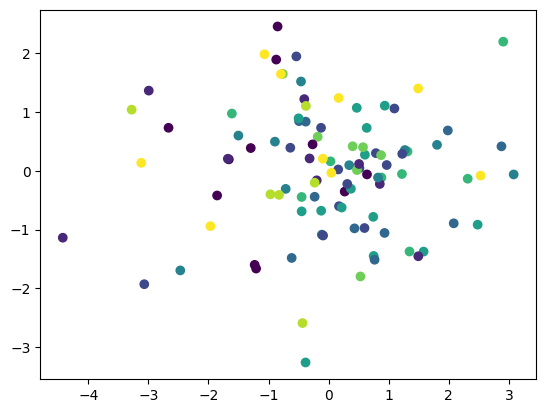

In [21]:
plt.scatter(x=x_pca[:, 0], y=x_pca[:, 1], c=y.cpu())

### Same Approach, but on MNIST

In [10]:
from torchvision import datasets, transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor
    transforms.Normalize((0.1307,), (0.3081,)) # Normalize pixel values
])
mnist_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=1000, shuffle=False)

In [11]:
class MnistResNet(nn.Module):
  def __init__(self):
    super(MnistResNet, self).__init__()
    self.conv_init = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=0),
      nn.BatchNorm2d(num_features=2),
      nn.ReLU()
    )
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)
    self.resblocks = nn.Sequential(
      ResidualBlock(in_channels=2, out_channels=4, kernel_size=3, downsample=True),
      ResidualBlock(in_channels=4, out_channels=8, kernel_size=3, downsample=True),
      ResidualBlock(in_channels=8, out_channels=16, kernel_size=3, downsample=True),
      ResidualBlock(in_channels=16, out_channels=32, kernel_size=3, downsample=True),
      ResidualBlock(in_channels=32, out_channels=64, kernel_size=3, downsample=True),
      ResidualBlock(in_channels=64, out_channels=128, kernel_size=3, downsample=True),
    )
    self.final_layer = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=128, out_features=32, bias=False),
    )
  
  def forward(self, X):
    X = self.conv_init(X)
    X = self.maxpool(X)
    X = self.resblocks(X)
    X = self.final_layer(X)
    return X

In [12]:
class MnistUnResNet(nn.Module):
  def __init__(self):
    super(MnistUnResNet, self).__init__()
    self.unproject = nn.Sequential(
      nn.Linear(in_features=32, out_features=128),
      nn.Unflatten(dim=-1, unflattened_size=[128, 1, 1]),
    )
    self.unresblocks = nn.Sequential(
      UnResidualBlock(in_channels=128, out_channels=64, kernel_size=3, in_shape=1, upsample=True),
      UnResidualBlock(in_channels=64, out_channels=32, kernel_size=3, in_shape=5, upsample=True),
      UnResidualBlock(in_channels=32, out_channels=16, kernel_size=3, in_shape=9, upsample=True),
      UnResidualBlock(in_channels=16, out_channels=8, kernel_size=3, in_shape=13, upsample=True),
      UnResidualBlock(in_channels=8, out_channels=4, kernel_size=3, in_shape=17, upsample=True),
      UnResidualBlock(in_channels=4, out_channels=2, kernel_size=3, in_shape=21, upsample=True),
    )
    self.rev_maxpool = nn.Upsample(size=26)
    self.rev_conv_init = nn.Sequential(
      nn.ReLU(),
      nn.BatchNorm2d(num_features=2),
      nn.ConvTranspose2d(in_channels=2, out_channels=1, kernel_size=3, stride=1, padding=0),       
    )

  def forward(self, X):
    X = self.unproject(X)
    X = self.unresblocks(X)
    X = self.rev_maxpool(X)
    X = self.rev_conv_init(X)
    return X

In [13]:
class MnistResNetAutoEncoder(nn.Module):
  def __init__(self):
    super(MnistResNetAutoEncoder, self).__init__()
    self.resnet = MnistResNet()
    self.unresnet = MnistUnResNet()
  
  def encode(self, X):
    return self.resnet(X)
  
  def decode(self, X_emb):
    return self.unresnet(X_emb)

  def forward(self, X):
    X_emb = self.encode(X) #embed X
    X_repr = self.decode(X_emb) #reproduce X
    return X_emb, X_repr
  
mrnae = MnistResNetAutoEncoder()
mrnae.to(device)
sum([p.numel() for p in mrnae.parameters()])

475113

In [ ]:
#train
criterion = nn.MSELoss()
lr = 1e-3
weight_decay = 1e-3
optimizer = optim.Adam(params=mrnae.parameters(), lr=lr, weight_decay=1e-3)


for epoch in range(5):
  for idx, (inputs, _) in enumerate(mnist_train_loader, 0):
    inputs = inputs.to(device)
    emb, repr = mrnae(inputs)
    optimizer.zero_grad()
    loss = criterion(repr, inputs)
    loss.backward()
    optimizer.step()

    if idx % 200 == 0:
      print(f'epoch {epoch}, batch {idx}: loss = {loss.item()}')

import datetime
ts = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
torch.save(mrnae.state_dict(), f'mrnae_{ts}.pt')

epoch 0, batch 0: loss = 1.4107391834259033
epoch 0, batch 200: loss = 0.49873149394989014
epoch 0, batch 400: loss = 0.33471766114234924
epoch 0, batch 600: loss = 0.30002909898757935
epoch 0, batch 800: loss = 0.2648252248764038
epoch 1, batch 0: loss = 0.23743689060211182
epoch 1, batch 200: loss = 0.23388776183128357
epoch 1, batch 400: loss = 0.21133068203926086
epoch 1, batch 600: loss = 0.20288397371768951
epoch 1, batch 800: loss = 0.19807690382003784
epoch 2, batch 0: loss = 0.19558867812156677
epoch 2, batch 200: loss = 0.20761260390281677
epoch 2, batch 400: loss = 0.2026994675397873
epoch 2, batch 600: loss = 0.1684744656085968
epoch 2, batch 800: loss = 0.1655965894460678
epoch 3, batch 0: loss = 0.1800897717475891
epoch 3, batch 200: loss = 0.1732417345046997
epoch 3, batch 400: loss = 0.16479270160198212
epoch 3, batch 600: loss = 0.17396171391010284
epoch 3, batch 800: loss = 0.1656690239906311
epoch 4, batch 0: loss = 0.1718316376209259
epoch 4, batch 200: loss = 0.192

NameError: name 'datetime' is not defined

In [16]:
import datetime
ts = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
torch.save(mrnae.state_dict(), f'mrnae_{ts}.pt')

In [27]:
compare_cos_similarity(mrnae, mnist_test_loader, device)

class    |  same class  |  diff class  |  ratio (same / diff)
-------------------------------------------------------------
class 0        0.71           0.56          1.27
class 1        0.75           0.54          1.38
class 2        0.67           0.55          1.21
class 3        0.66           0.55          1.20
class 4        0.69           0.57          1.21
class 5        0.64           0.56          1.15
class 6        0.68           0.56          1.22
class 7        0.70           0.57          1.22
class 8        0.64           0.55          1.16
class 9        0.70           0.57          1.23


In [28]:
untrained_mrnae = MnistResNetAutoEncoder()
untrained_mrnae.to(device)

compare_cos_similarity(untrained_mrnae, mnist_test_loader, device)

class    |  same class  |  diff class  |  ratio (same / diff)
-------------------------------------------------------------
class 0        0.66           0.65          1.03
class 1        0.66           0.64          1.02
class 2        0.66           0.65          1.02
class 3        0.65           0.64          1.01
class 4        0.65           0.64          1.01
class 5        0.65           0.64          1.01
class 6        0.65           0.65          1.01
class 7        0.66           0.65          1.02
class 8        0.64           0.64          1.00
class 9        0.65           0.65          1.01


### Demonstraiton on several examples

In [29]:
x, y = next(iter(mnist_train_loader))
img_emb, img_repr = mrnae(x.to(device))

tensor(8)


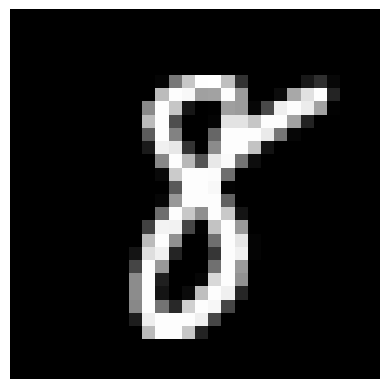

In [30]:
idx = 10

print(y[idx])
plt.imshow(x[idx].squeeze(0), cmap='gray')
plt.axis('off')
plt.savefig('9_ae_compare_in.png', bbox_inches='tight', pad_inches=0)
plt.show()

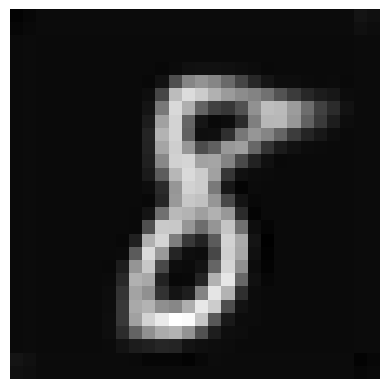

In [31]:
plt_img = img_repr[idx].squeeze(0).cpu().detach().numpy()
plt.imshow(plt_img, cmap='gray')
plt.axis('off')
plt.savefig('9_ae_compare_out.png', bbox_inches='tight', pad_inches=0)
plt.show()